# Part 3: Advanced Model 

In [30]:
from cleantext import clean
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from functools import reduce
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from scipy.sparse import csr_matrix
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliagrundemar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df_big_cleaned = pd.read_csv('cleaned_dataset.csv') 
#Omitting 'unknown', 'unreliable' and 'rumor' types and dropping nan values
df_big_cleaned = df_big_cleaned.dropna(subset=['type'])
df_big_cleaned = df_big_cleaned[df_big_cleaned['type'] != 'unknown']
df_big_cleaned = df_big_cleaned[df_big_cleaned['type'] != 'unreliable']
df_big_cleaned = df_big_cleaned[df_big_cleaned['type'] != 'rumor']

#Grouping the types 'bias','clickbait','conspiracy','fake','hate','junksci','unreliable' into 'fake'
df_big_cleaned['type'] = df_big_cleaned['type'].replace(['bias','conspiracy','fake','hate','junksci','satire'],'fake')
df_big_cleaned['type'] = df_big_cleaned['type'].replace(['political','reliable','clickbait'],'reliable')
df_big_cleaned = df_big_cleaned[['content','type']]

#Splitting data into training, validation and test data
reliable = pd.read_csv('reliable_scraped_data.csv') #reading the csv file as a pandas dataframe#
reliable['type'] = 'reliable'
reliable = reliable[['content','type']]

#Adding the reliable data to our dataset 
concatenated_data = pd.concat([df_big_cleaned,reliable],axis=0)
concatenated_data.drop(concatenated_data[concatenated_data['type'] == '2018-02-10 13:43:39.521661'].index, inplace=True)
label_mapping = {"fake": 0, "reliable": 1}
concatenated_data['type'] = concatenated_data['type'].replace(label_mapping)
concatenated_data = concatenated_data.iloc[:, 0:2]
concatenated_data = concatenated_data.dropna().reset_index(drop=True)
print(concatenated_data)

#Defining our x to be our input data from the content column and y to be the type column
x=concatenated_data['content']
print(x.shape)
y=concatenated_data['type']

#Splitting the data into training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5,random_state=42)
y_train = y_train.astype(int)
y_validation = y_validation.astype(int)
y_test = y_test.astype(int)

print(y.isna().sum())
print(x_train)
print(y_train)

                                                content  type
0      plu one articl googl plu (thank ali alfoneh a...     1
1      cost best senat bank committe jp morgan buy: ...     0
2      man awoken <num>-year coma commit suicid lear...     0
3      julia geist ask draw pictur comput scientist ...     1
4      <num> compil studi vaccin danger (activist po...     0
...                                                 ...   ...
5581   teenag iranian girl fell coma alleg alterc mo...     1
5582   jewish univers student say told show outright...     1
5583   israel carri air strike jenin northern occupi...     1
5584   ex-labour mp quit parti comment made sir keir...     1
5585                                                nan     1

[5586 rows x 2 columns]
(5586,)
0
4270     descend former prime minist william gladston ...
2384     week end, australian nurseri owner humphrey h...
1864     news henri kissinger' death spread week, mani...
1173     rishi sunak face crucial vote rwanda b

# Part 4: Evaluation 

In [32]:
#Functions for cleaning, stemming and removing stopwords
def remove_stopwords(data):
    stop_words = set(stopwords.words('english'))
    words = str(data).split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def stem_input(data):
    ps = PorterStemmer()
    words = str(data).split()
    return reduce(lambda x, y: x + ' ' + ps.stem(y), words, '')

def cleantext_clean(data):
    #As clean did not have arguments for date we wrote our own using regular expressions
    date_formats = [
        r'\d{2,4}/\d{1,2}/\d{2,4}(.*)',   # e.g 12/31/2021 or 12/31/21
        r'\d{2,4}-\d{1,2}-\d{2,4}(.*)',   # e.g 12-31-2021 or 12-31-21
        ]

    for date_format in date_formats:
        data = re.sub(date_format, '<DATE>', str(data))

    data = clean(data, lower=True, normalize_whitespace=True, no_urls=True, no_emails = True, no_numbers= True,
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_number="<NUM>",)
    return data

#Cleaning the LIAR-dataset for testing
liar_dataset = pd.read_csv('test.tsv',sep='\t', header=None)
liar_dataset[1].unique()
liar_dataset = liar_dataset[liar_dataset[1] != 'half-true']
liar_dataset[1] = liar_dataset[1].replace(['false','barely-true','pants-fire'],0)
liar_dataset[1] = liar_dataset[1].replace(['true','mostly-true'],1)
x_liar=liar_dataset[2]
y_liar=liar_dataset[1]
x_liar = x_liar.apply(cleantext_clean)
x_liar = x_liar.apply(remove_stopwords)
x_liar = x_liar.apply(stem_input)

In [34]:
#Evaluating the simple model on the LIAR-dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle

#Loading the CountVectorizer used for training
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

#Transforming validation data using the same CountVectorizer
x_liar_vec = vectorizer.transform(x_liar)

#Loading the trained model
with open('trained_model_content.pkl', 'rb') as f:
    model = pickle.load(f)

#Making predictions on validation data
y_pred = model.predict(x_liar_vec)

y_pred = pd.DataFrame({'type': y_pred})
y_pred = y_pred.replace(label_mapping)
#Calculating accuracy
acc = accuracy_score(y_liar, y_pred)
print("Accuracy:", acc)

Accuracy: 0.48502994011976047


In [35]:
#Evaluating the advanced model on the LIAR-dataset
import tensorflow as tf
from tensorflow.keras.initializers import Constant

#Tokenizing the data
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(x_train)

#Converting the text to sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_validation = tokenizer.texts_to_sequences(x_validation)
x_test = tokenizer.texts_to_sequences(x_test)
x_liar = tokenizer.texts_to_sequences(x_liar)
vocab_size = len(tokenizer.word_index) + 1

#Padding the sequences
max_sequence_length = 100
x_train = pad_sequences(x_train, maxlen=max_sequence_length,padding='post')
x_validation = pad_sequences(x_validation, maxlen=max_sequence_length,padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_length,padding='post')
x_liar = pad_sequences(x_liar, maxlen=max_sequence_length,padding='post')

#Converting the sequences back to text
sentences = tokenizer.sequences_to_texts(x_train)
sentences = [article.split() for article in sentences]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#Creating a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
        
#Setting up early stopping callback 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

#Building the model 
model = Sequential()
model.add(Embedding(vocab_size, 100,embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Training the model
model.fit(x_train, y_train, epochs=30, batch_size=256, validation_data=(x_validation, y_validation),callbacks=[callback])

#Evaluating the model
loss, accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy: ', accuracy)
loss_liar, accuracy_liar = model.evaluate(x_liar, y_liar)
print('Liar Accuracy: ', accuracy_liar)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.7788 - loss: 0.4111 - val_accuracy: 0.9177 - val_loss: 0.2767
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9379 - loss: 0.2050 - val_accuracy: 0.9177 - val_loss: 0.2457
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9342 - loss: 0.2125 - val_accuracy: 0.9177 - val_loss: 0.2500
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9341 - loss: 0.2047 - val_accuracy: 0.9177 - val_loss: 0.2362
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9391 - loss: 0.1763 - val_accuracy: 0.9195 - val_loss: 0.2276
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9429 - loss: 0.1728 - val_accuracy: 0.9195 - val_loss: 0.2169
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9420 - loss: 0.1700 - val_accuracy: 0.9231 - val_loss: 0.2110
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9491 - loss: 0.1399 - val_accuracy: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.9212880143112702
F1-score: 0.9587242026266416
Confusion Matrix:
 [[  4  44]
 [  0 511]]


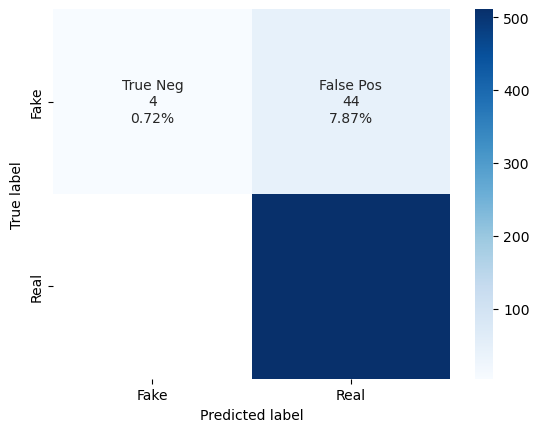

In [36]:
#Function to make a confusion matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
                          xyplotlabels=True, sum_stats=True, figsize=None, cmap='Blues', title=None):

    # Function to generate text inside each square
    def generate_labels(cf, count, percent):
        blanks = ['' for _ in range(cf.size)]
        if group_names and len(group_names) == cf.size:
            group_labels = ["{}\n".format(value) for value in group_names]
        else:
            group_labels = blanks

        if count:
            group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
        else:
            group_counts = blanks

        if percent:
            group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
        else:
            group_percentages = blanks

        box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in
                      zip(group_labels, group_counts, group_percentages)]
        return np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    box_labels = generate_labels(cf, count, percent)

    #Setting figure parameters according to other arguments
    if figsize is None:
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        categories = False

    colors = ['Reds', 'Greens']

    # Makeing the heatmap visualization
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories, 
                mask=cf == 0)  # Mask zeros to avoid displaying empty cells

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if title:
        plt.title(title)

    plt.show() 
    

 #Generating confusion matrix and f1-score for the the advanced model    
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", acc)

#Calculating F1-score
f1 = f1_score(y_test, y_pred_binary)
print("F1-score:", f1)

#Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix) 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real']

make_confusion_matrix(conf_matrix, group_names=labels, categories=categories, cmap='Blues')